# Obraz - transfer learning - praca domowa
Ostatnia aktualizacja: 2023.04.29

Uwaga: praca jest jednoosobowa. 

Z dokumentacji [Keras](https://keras.io/guides/transfer_learning/): *Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem.*

Głównym celem pracy domowej jest stworzenie klasyfikatora, który będzie odróżniał zdjęcia obiektów w wybranym przez nas zbiorze. Użyjemy do tego jednego z [gotowych modeli Keras](https://keras.io/api/applications/), wytrenowanego wcześniej na zbiorze Imagenet. 

Przydatne źródła:
- [transfer learning vgg16 + tf_flowers](https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4)
- [Keras - transfer learning](https://keras.io/guides/transfer_learning/)

### Wybierz swój zbiór danych ### 
Chcemy mieć co najmniej 2-3 klasy. Możesz użyć gotowego zbioru (np. z [katalogu tensorflow](https://www.tensorflow.org/datasets/catalog/overview) lub [kaggle](https://www.kaggle.com/datasets)) albo użyć własnych danych. 
- [Przykładowy zbiór: tf_flowers](https://www.tensorflow.org/datasets/catalog/tf_flowers). 
- [Przykładowy zbiór: plant_leaves](https://www.tensorflow.org/datasets/catalog/plant_leaves). 

Wczytaj i przygotuj dane do treningu. 



Wybrane dane: https://www.kaggle.com/datasets/puneet6060/intel-image-classification

In [1]:
import os
from pathlib import Path

DATASET_DIR = Path(os.getcwd(), 'intel_image')

SEG_TRAIN_DIR = DATASET_DIR / 'seg_train' / 'seg_train' # 14k
SEG_TEST_DIR = DATASET_DIR / 'seg_test' / 'seg_test' # 3k

In [2]:
IMG_HEIGHT = IMG_WIDTH = 150
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
CHANNELS = 3
SEED = 41
BATCH_SIZE = 32

In [10]:
def count_dir_files(dirs, dirs_names):
    for dir, dir_name in zip(dirs, dirs_names):
        dir_elements = 0
        for class_dir in dir.iterdir():
            class_images = sum(1 for class_image in class_dir.iterdir() if class_image.is_file())
            print(f'{class_images} images found for class {class_dir.name} in {dir_name} directory')
            dir_elements += class_images
        print(f'{dir_elements} images found for {dir_name} directory overall', end='\n\n')

count_dir_files((SEG_TRAIN_DIR, SEG_TEST_DIR), ('seg_train', 'seg_test'))

2191 images found for class buildings in seg_train directory
2271 images found for class forest in seg_train directory
2404 images found for class glacier in seg_train directory
2512 images found for class mountain in seg_train directory
2274 images found for class sea in seg_train directory
2382 images found for class street in seg_train directory
14034 images found for seg_train directory overall

437 images found for class buildings in seg_test directory
474 images found for class forest in seg_test directory
553 images found for class glacier in seg_test directory
525 images found for class mountain in seg_test directory
510 images found for class sea in seg_test directory
501 images found for class street in seg_test directory
3000 images found for seg_test directory overall



In [4]:
from math import floor

all_labeled_images = 14034 + 3000
train_size = floor(0.7 * all_labeled_images)
val_size = floor(0.2 * all_labeled_images)
test_size = floor(0.1 * all_labeled_images)
train_size, val_size, test_size

(11923, 3406, 1703)

Niech obrazy z seg_test zostaną obrazami walidacyjnymi, jednak obrazy z set_train trzeba rozdzielić na foldery treningowe (12k) i testowe (2k)

In [25]:
SPLIT_DIR = DATASET_DIR / 'split'

TRAIN_DATA_DIR = SPLIT_DIR / 'train'
VAL_DATA_DIR = SEG_TEST_DIR
TEST_DATA_DIR = SPLIT_DIR / 'test'

SPLIT_DIR.mkdir(exist_ok=True)
TRAIN_DATA_DIR.mkdir(exist_ok=True)
TEST_DATA_DIR.mkdir(exist_ok=True)

In [26]:
import shutil

def copy_img(file, src, dest):
    shutil.copy(src, dest / file)

In [27]:
import multiprocessing as mp

for class_dir in SEG_TRAIN_DIR.iterdir():
    TRAIN_DATA_DIR.joinpath(class_dir.name).mkdir()
    TEST_DATA_DIR.joinpath(class_dir.name).mkdir()
    class_dir_images_count = sum(1 for class_img in class_dir.iterdir() if class_img.is_file())
    train_size = 6 * class_dir_images_count // 7  # (12 + 2) / 14 proporcje 
    for i, path_to_img in enumerate(SEG_TEST_DIR.joinpath(class_dir).iterdir()):
        train_or_test_dir = TRAIN_DATA_DIR if i < train_size else TEST_DATA_DIR
        process = mp.Process(
            target=copy_img,
            args=(path_to_img.name, path_to_img, train_or_test_dir / class_dir.name))
        process.start()

In [28]:
count_dir_files((TRAIN_DATA_DIR, VAL_DATA_DIR, TEST_DATA_DIR), ('train', 'validation', 'test'))

1878 images found for class buildings in train directory
1946 images found for class forest in train directory
2060 images found for class glacier in train directory
2153 images found for class mountain in train directory
1949 images found for class sea in train directory
2041 images found for class street in train directory
12027 images found for train directory overall

437 images found for class buildings in validation directory
474 images found for class forest in validation directory
553 images found for class glacier in validation directory
525 images found for class mountain in validation directory
510 images found for class sea in validation directory
501 images found for class street in validation directory
3000 images found for validation directory overall

313 images found for class buildings in test directory
325 images found for class forest in test directory
344 images found for class glacier in test directory
359 images found for class mountain in test directory
325 imag

In [77]:
from keras.utils import image_dataset_from_directory

train_ds = image_dataset_from_directory(
    TRAIN_DATA_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = image_dataset_from_directory(
    VAL_DATA_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_ds = image_dataset_from_directory(
    TEST_DATA_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 12027 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Found 2007 files belonging to 6 classes.


In [31]:
class_names = train_ds.class_names
num_of_classes = len(class_names)
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

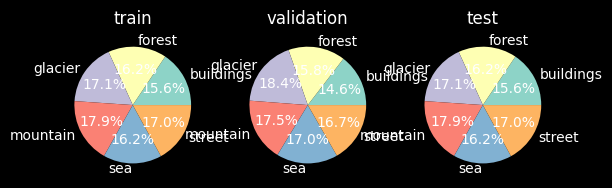

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline

for i, (ds, name) in enumerate(zip((TRAIN_DATA_DIR, VAL_DATA_DIR, TEST_DATA_DIR), ('train', 'validation', 'test'))):
    imgs_count = {}
    for label in class_names:
        label_dir: Path = ds / label
        imgs_count[label] = len([label_dir_el for label_dir_el in label_dir.iterdir() if label_dir_el.is_file()])
    plt.subplot(1, 3, i+1)
    plt.pie(imgs_count.values(), labels=imgs_count.keys(), autopct='%1.1f%%')
    plt.title(name)

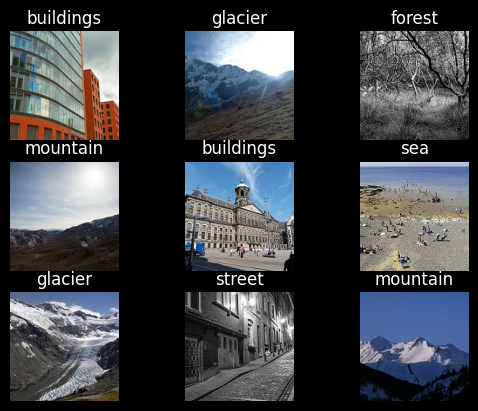

In [73]:
import numpy as np

for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype(np.uint8))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [76]:
for ds, name in zip((train_ds, val_ds, test_ds), ('train', 'val', 'test')):
    for rnd_img, rnd_label in ds.take(1):
        print(name, len(ds.class_names), rnd_img.shape, np.max(rnd_img))

train 6 (32, 150, 150, 3) 255.0
val 6 (32, 150, 150, 3) 255.0
test 6 (32, 150, 150, 3) 255.0


In [78]:
import tensorflow as tf

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### Wczytaj wytrenowany model do klasyfikacji obrazu. ###
Może to być jeden z gotowych [modeli dostępnych w Keras](https://keras.io/api/applications/). Wczytujemy go z wytrenowanymi już wcześniej wagami na Imagenecie (weights='imagenet'). 

Model możemy wczytać bez ostatnich warstw (include_top=False) i dodać je potem ręcznie, dostosowane do liczby klas w naszym zbiorze. Imagenet ma 1000 klas, my prawdopodobnie będziemy mieć ich mniej. 

Pamiętaj, żeby wyłączyć lub ograniczyć trening części modelu z wytrenowanymi już wagami (trainable=False). 

In [79]:
from keras.applications.vgg16 import VGG16

vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
vgg16.trainable = False

In [80]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [81]:
from keras.models import Sequential
from keras.layers import Dense, Flatten

model1 = Sequential([
    vgg16,
    Flatten(),
    Dense(64, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_of_classes, activation='softmax')
])

In [82]:
model1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

### Zadanie 1: Wytrenuj model na swoich danych ###
**(Zadanie na ocenę 3)**

Wytrenuj wybrany model na swoich danych. Omów eksperyment i wyniki (100-150 słów). 

In [83]:
from keras.callbacks import EarlyStopping

EPOCHS = 25

early_stopping = EarlyStopping(
    patience=10,
    restore_best_weights=True
)

In [84]:
model1_hist = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping]
)

Epoch 1/25
376/376 [==============================] - 39s 88ms/step - loss: 0.9249 - accuracy: 0.7779 - val_loss: 0.6154 - val_accuracy: 0.8533
Epoch 2/25
376/376 [==============================] - 27s 72ms/step - loss: 0.4479 - accuracy: 0.8774 - val_loss: 0.4671 - val_accuracy: 0.8707
Epoch 3/25
376/376 [==============================] - 27s 73ms/step - loss: 0.2745 - accuracy: 0.9140 - val_loss: 0.4209 - val_accuracy: 0.8687
Epoch 4/25
376/376 [==============================] - 26s 70ms/step - loss: 0.1884 - accuracy: 0.9346 - val_loss: 0.4208 - val_accuracy: 0.8677
Epoch 5/25
376/376 [==============================] - 26s 69ms/step - loss: 0.1331 - accuracy: 0.9520 - val_loss: 0.4752 - val_accuracy: 0.8833
Epoch 6/25
376/376 [==============================] - 26s 69ms/step - loss: 0.1181 - accuracy: 0.9602 - val_loss: 0.5243 - val_accuracy: 0.8800
Epoch 7/25
376/376 [==============================] - 26s 69ms/step - loss: 0.0899 - accuracy: 0.9708 - val_loss: 0.5788 - val_accuracy:

In [85]:
model1.evaluate(test_ds)

63/63 [==============================] - 6s 101ms/step - loss: 0.4147 - accuracy: 0.8749


[0.41469043493270874, 0.8749377131462097]

In [86]:
MODELS_PATH = Path('models')

model1.save(MODELS_PATH / 'model1.h5')

*TODO: omówienie (100-150 słów)*

### Zadanie 2: Dodatkowe sieci ###
**(Zadanie na ocenę 4, po wykonaniu  zadania 1)**

Przeprowadź to samo na dwóch dodatkowych sieciach i omów wyniki (50-100 słów). 

Czyli jeśli w zadaniu 1 użyliśmy np. VGG to teraz wybieramy sobie np. ResNet i MobileNet. 

In [87]:
from keras.applications.resnet import ResNet50

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
resnet.trainable = False
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']      

In [88]:
model2 = Sequential([
    resnet,
    Flatten(),
    Dense(64, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_of_classes, activation='softmax')
])

model2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [89]:
model2_hist = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    batch_size=BATCH_SIZE
)

Epoch 1/25
376/376 [==============================] - 26s 61ms/step - loss: 0.6079 - accuracy: 0.8408 - val_loss: 0.4124 - val_accuracy: 0.8850
Epoch 2/25
376/376 [==============================] - 21s 55ms/step - loss: 0.2652 - accuracy: 0.9148 - val_loss: 0.3602 - val_accuracy: 0.8953
Epoch 3/25
376/376 [==============================] - 21s 55ms/step - loss: 0.1532 - accuracy: 0.9510 - val_loss: 0.4414 - val_accuracy: 0.8907
Epoch 4/25
376/376 [==============================] - 20s 54ms/step - loss: 0.1088 - accuracy: 0.9630 - val_loss: 0.4514 - val_accuracy: 0.8933
Epoch 5/25
376/376 [==============================] - 21s 55ms/step - loss: 0.1016 - accuracy: 0.9684 - val_loss: 0.5128 - val_accuracy: 0.8917
Epoch 6/25
376/376 [==============================] - 20s 54ms/step - loss: 0.0883 - accuracy: 0.9729 - val_loss: 0.6132 - val_accuracy: 0.8793
Epoch 7/25
376/376 [==============================] - 21s 55ms/step - loss: 0.0774 - accuracy: 0.9753 - val_loss: 0.5598 - val_accuracy:

In [90]:
model2.evaluate(test_ds)

63/63 [==============================] - 4s 57ms/step - loss: 0.3492 - accuracy: 0.9028


[0.34922730922698975, 0.9028400778770447]

In [91]:
model2.save(MODELS_PATH / 'model2.h5')

In [92]:
from keras.applications.mobilenet import MobileNet

mobile_net = MobileNet(input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS), include_top=False, weights='imagenet')
mobile_net.trainable = False
mobile_net.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 75, 75, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 75, 75, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 75, 75, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 75, 75, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 75, 75, 32)       128       
 ation)                                         

In [93]:
model3 = Sequential([
    mobile_net,
    Flatten(),
    Dense(64, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_of_classes, activation='softmax')
])

model3.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [94]:
model3_hist = model3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    batch_size=BATCH_SIZE
)

Epoch 1/25
376/376 [==============================] - 11s 24ms/step - loss: 0.7913 - accuracy: 0.7203 - val_loss: 0.6222 - val_accuracy: 0.7857
Epoch 2/25
376/376 [==============================] - 8s 22ms/step - loss: 0.4669 - accuracy: 0.8270 - val_loss: 0.5827 - val_accuracy: 0.7923
Epoch 3/25
376/376 [==============================] - 8s 22ms/step - loss: 0.3576 - accuracy: 0.8705 - val_loss: 0.6091 - val_accuracy: 0.7937
Epoch 4/25
376/376 [==============================] - 8s 22ms/step - loss: 0.2901 - accuracy: 0.8936 - val_loss: 0.6600 - val_accuracy: 0.7813
Epoch 5/25
376/376 [==============================] - 8s 21ms/step - loss: 0.2515 - accuracy: 0.9107 - val_loss: 0.7503 - val_accuracy: 0.7727
Epoch 6/25
376/376 [==============================] - 8s 20ms/step - loss: 0.2619 - accuracy: 0.9058 - val_loss: 0.6826 - val_accuracy: 0.7840
Epoch 7/25
376/376 [==============================] - 8s 21ms/step - loss: 0.2375 - accuracy: 0.9162 - val_loss: 0.8336 - val_accuracy: 0.770

In [95]:
model3.evaluate(test_ds)

63/63 [==============================] - 1s 20ms/step - loss: 0.5971 - accuracy: 0.7838


[0.5971267223358154, 0.7837568521499634]

In [96]:
model3.save(MODELS_PATH / 'model3.h5')

*TODO: omówienie (50-100 słów)*

### Zadanie 3: Trening od zera i porównanie ###
**(Zadanie na ocenę 5, po wykonaniu zadania 1 i 2)**

Spróbuj skonstruować swój własny model i wytrenować go 'od zera' na tych samych danych. Porównaj i omów swój eksperyment i wyniki (100-150 słów).

In [97]:
from keras.layers import RandomFlip, RandomRotation, RandomZoom

AUGMENTATION_FACTOR = 0.15

data_augmentation = Sequential([
    RandomFlip(mode='horizontal', seed=SEED),
    RandomRotation(AUGMENTATION_FACTOR / 3, seed=SEED),
    RandomZoom(AUGMENTATION_FACTOR / 2, AUGMENTATION_FACTOR / 2, seed=SEED)
])

In [98]:
from keras.layers import BatchNormalization, Dropout, Rescaling, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input, Rescaling

DROPOUT = 0.1

model4 = Sequential([
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
    Rescaling(1 / 255.),
    data_augmentation,

    Conv2D(32, kernel_size=3, activation='relu'),
    Conv2D(32, kernel_size=3, activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
    Dropout(DROPOUT),

    Conv2D(64, kernel_size=3, activation='relu'),
    Conv2D(64, kernel_size=3, activation='relu'),
    MaxPooling2D(),
    Dropout(DROPOUT),

    Conv2D(128, kernel_size=3, activation='relu'),
    Conv2D(128, kernel_size=3, activation='relu'),
    MaxPooling2D(),
    Dropout(DROPOUT),

    Conv2D(256, kernel_size=3, activation='relu'),
    Conv2D(256, kernel_size=3, activation='relu'),
    Conv2D(256, kernel_size=5, activation='relu'),
    GlobalAveragePooling2D(),
    Dropout(DROPOUT),

    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_of_classes, activation='softmax')
])

model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 sequential_3 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 73, 73, 32)       128       
 ormalization)                                        

In [99]:
model4.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model4_hist = model4.fit(
    train_ds,
    validation_data=val_ds,
    epochs=300,
    callbacks=[early_stopping],
    batch_size=BATCH_SIZE
)

Epoch 1/300


2023-05-15 22:50:54.716795: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


376/376 [==============================] - 62s 148ms/step - loss: 1.3511 - accuracy: 0.4256 - val_loss: 1.1821 - val_accuracy: 0.5137
Epoch 2/300
376/376 [==============================] - 52s 138ms/step - loss: 1.0133 - accuracy: 0.5914 - val_loss: 0.8783 - val_accuracy: 0.6520
Epoch 3/300
376/376 [==============================] - 52s 137ms/step - loss: 0.8672 - accuracy: 0.6728 - val_loss: 1.0905 - val_accuracy: 0.6200
Epoch 4/300
376/376 [==============================] - 51s 136ms/step - loss: 0.7786 - accuracy: 0.7192 - val_loss: 0.7742 - val_accuracy: 0.7397
Epoch 5/300
376/376 [==============================] - 51s 136ms/step - loss: 0.6930 - accuracy: 0.7517 - val_loss: 0.9431 - val_accuracy: 0.7200
Epoch 6/300
376/376 [==============================] - 53s 141ms/step - loss: 0.6570 - accuracy: 0.7649 - val_loss: 0.7480 - val_accuracy: 0.7397
Epoch 7/300
376/376 [==============================] - 52s 138ms/step - loss: 0.6036 - accuracy: 0.7861 - val_loss: 0.5605 - val_accurac

In [100]:
model4.evaluate(test_ds)

63/63 [==============================] - 1s 23ms/step - loss: 0.4653 - accuracy: 0.8455


[0.4653123915195465, 0.8455405831336975]

In [153]:
model4.save(MODELS_PATH / 'model4.h5')

*TODO: omówienie (100-150 słów)*

To wszystko, dziękuję. Wypełniony notatnik zapisz jako .ipynb i oddaj w Teams. 